<a href="https://colab.research.google.com/github/Linthevanrooij/FAIP/blob/main/Final_project/Image-generator/Multi_class_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'eeg-dataset-for-emotion-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4751397%2F8055982%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241007%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241007T092606Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9ca71f4d23e65d00333bb1fcb302550b4e21ab020f24d9a6cce8e0df299b7e215db95857859408132f3b214ceaa8d0d5ac01549ecab7c92c59e4dc628f0faeece00230d235a754b01b749f2da5d326aaa09dea5ef46b08b7f9f477d5cc23506eb92201437a9c790fa31edef85cf1532cda29bf9e9955ceacb0359e1081a01cefcf7fe2b4eaf6126b92c032677040d0cce35374c8ad4631ac3383c60a0c3cdb3ef151e89181cdb04ad440944566959ee1bd2620274f3a8b279f924e59de4746c20f43b21ff3881cef2061f1238720fdee08c9c68141974f7d664e875c735ceb3e1020c6f475dfafde2dd909b97a2f286c249a402043f8985442c6f73099910edb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 190266329 bytes downloaded
Downloaded and uncompressed: eeg-dataset-for-emotion-recognition
Data source import complete.


# **Import Libraries**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Read Data**

In [35]:

# Directory containing the CSV files
directory = '/kaggle/input/eeg-dataset-for-emotion-recognition/Data/'

# Initialize lists to store EEG channels and labels
all_eeg_channels = []
all_labels = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # print(file_path)
        # Read the CSV file
        data = pd.read_csv(file_path)

        # Select the EEG channels columns
        eeg_channels = data[['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']][:-2]

        # Select the valence and arousal columns
        labels = data[['valence', 'arousal']].iloc[0]

        # Convert EEG channels and labels to arrays and store them
        all_eeg_channels.append(eeg_channels.values)
        all_labels.append(labels.values)

# Convert lists to arrays
all_eeg_channels_array = np.array(all_eeg_channels)
all_labels_array = np.array(all_labels)

# Print the shapes of the arrays
print("All EEG Channels Array Shape:", all_eeg_channels_array.shape)
print("All Labels Array Shape:", all_labels_array.shape)


All EEG Channels Array Shape: (100, 38250, 14)
All Labels Array Shape: (100, 2)


In [39]:
data

,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,O2,P7,P8,T7,T8,valence,arousal
0,46.5180,9.39990,48.44610,-38.80520,-28.2001,-55.194800,-69.1743,-8.43600,-3.1334,41.6972,131.84090,51.33820,3.1334,-29.6461,3.0,2.5
1,40.8347,22.93590,59.63940,-22.37690,-12.4081,-37.783100,-50.9239,-12.26830,11.1546,25.0954,112.84350,44.40190,-3.3213,-13.7674,3.0,2.5
2,24.2846,35.65970,56.18140,-6.93430,2.4364,-21.416100,-36.1787,-25.63220,24.5854,9.4897,91.97290,27.63780,-17.2220,-8.4824,3.0,2.5
3,8.7275,33.52030,59.07750,4.08700,-1.0841,-6.031200,-36.9003,-38.19430,37.2102,-5.1797,72.35450,22.00260,-30.2887,3.1138,3.0,2.5
4,16.8805,18.97580,56.01500,5.28780,-1.0189,-0.005093,-20.5862,-49.88190,49.0776,-18.9689,61.26440,29.35930,-26.0612,1.4809,3.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38247,1.5297,-0.36388,-13.76190,-15.79260,-8.4262,-22.889200,-17.2481,11.18490,-16.6372,5.4164,13.18420,-6.94840,-10.2416,-16.5643,3.0,2.5
38248,5.0534,9.53990,-0.64393,-0.74508,6.1794,-7.415800,-2.1132,-0.33268,-1.5390,5.9351,-1.70680,-0.50575,3.6290,-5.6885,3.0,2.5
38249,4.2682,14.27010,13.49470,13.39960,19.9086,7.129100,12.1136,-14.41270,12.6534,-8.5210,-15.70440,0.48846,-3.8191,8.7528,3.0,2.5
38250,18.1121,17.75250,15.93900,22.23660,22.0886,20.801400,8.0123,-0.41159,-2.2058,-22.1098,-15.72600,-0.98688,9.4252,12.9276,3.0,2.5


In [11]:
def map_labels(valence, arousal):
    if valence <= 2.5 and arousal <= 2.5:
        return 0  # Low valence, low arousal
    elif valence <= 2.5 and arousal > 2.5:
        return 1  # Low valence, high arousal
    elif valence > 2.5 and arousal <= 2.5:
        return 2  # High valence, low arousal
    else:
        return 3  # High valence, high arousal

# Example usage:
labels_mapped = np.array([map_labels(valence, arousal) for valence, arousal in all_labels_array])
labels_mapped

array([0, 1, 3, 3, 0, 3, 3, 0, 1, 3, 0, 0, 3, 0, 2, 3, 1, 0, 2, 3, 3, 1,
       3, 3, 3, 3, 1, 0, 2, 3, 3, 0, 0, 1, 3, 3, 0, 2, 2, 3, 0, 2, 3, 1,
       3, 1, 1, 0, 3, 3, 3, 2, 3, 0, 1, 3, 3, 0, 3, 1, 0, 0, 2, 0, 2, 1,
       0, 2, 3, 3, 1, 1, 2, 1, 2, 3, 3, 1, 3, 3, 2, 0, 1, 3, 3, 1, 3, 1,
       3, 0, 3, 3, 0, 1, 2, 2, 0, 0, 2, 2])

**Check Shape and Data Types:** Verify the shape and data types of the arrays.

**Summary Statistics:** Calculate basic summary statistics such as mean, median, minimum, maximum, and standard deviation for EEG channels.

**Visualization:** Plot histograms or boxplots for each EEG channel to understand their distributions.

**Correlation Analysis:** Compute correlation coefficients between EEG channels and visualize them using a heatmap.

**Label Analysis:** Plot histograms or boxplots for valence and arousal labels to understand their distributions.

**Label Correlation:** Compute correlation between valence and arousal labels.

**Feature Engineering:** Explore potential feature engineering techniques such as Fourier transforms, wavelet transforms, or other signal processing methods.

**Outlier Detection:** Detect and handle outliers if present in the data.

#**Plots and stuff**


In [13]:
# 1. Check Shape and Data Types
print("All EEG Channels Array Shape:", all_eeg_channels_array.shape)
print("All Labels Array Shape:", all_labels_array.shape)
print("Data Type of EEG Channels Array:", all_eeg_channels_array.dtype)
print("Data Type of Labels Array:", all_labels_array.dtype)

# 2. Summary Statistics
eeg_summary = np.hstack((np.mean(all_eeg_channels_array, axis=1), np.median(all_eeg_channels_array, axis=1),
                         np.min(all_eeg_channels_array, axis=1), np.max(all_eeg_channels_array, axis=1),
                         np.std(all_eeg_channels_array, axis=1)))
print("Summary Statistics for EEG Channels:")
print("Mean, Median, Min, Max, Std Dev")
print(eeg_summary)

All EEG Channels Array Shape: (100, 38250, 14)
All Labels Array Shape: (100, 6, 2)
Data Type of EEG Channels Array: float64
Data Type of Labels Array: float64
Summary Statistics for EEG Channels:
Mean, Median, Min, Max, Std Dev
[[-5.40794161e-02 -3.46433888e-02  2.73945644e-02 ...  1.46181277e+01
   1.08660057e+01  1.13630247e+01]
 [ 2.73947590e-02  5.50462017e-04 -4.02593570e-03 ...  6.36776100e+00
   6.78632292e+00  5.62296530e+00]
 [-8.27623750e-03 -3.88346345e-03  1.47619120e-01 ...  1.20059940e+01
   9.29348571e+00  1.06478060e+01]
 ...
 [ 1.23875470e-03  1.80737810e-02 -3.95845532e-04 ...  2.78863656e+01
   8.77137269e+00  7.67649598e+00]
 [ 7.12007802e-03  4.86428795e-03  1.81679860e-02 ...  1.98886011e+01
   1.13907933e+01  1.21921185e+01]
 [ 9.48930781e-03  2.45194411e-03  2.36163681e-02 ...  1.19824010e+01
   1.73920101e+01  9.11727600e+00]]


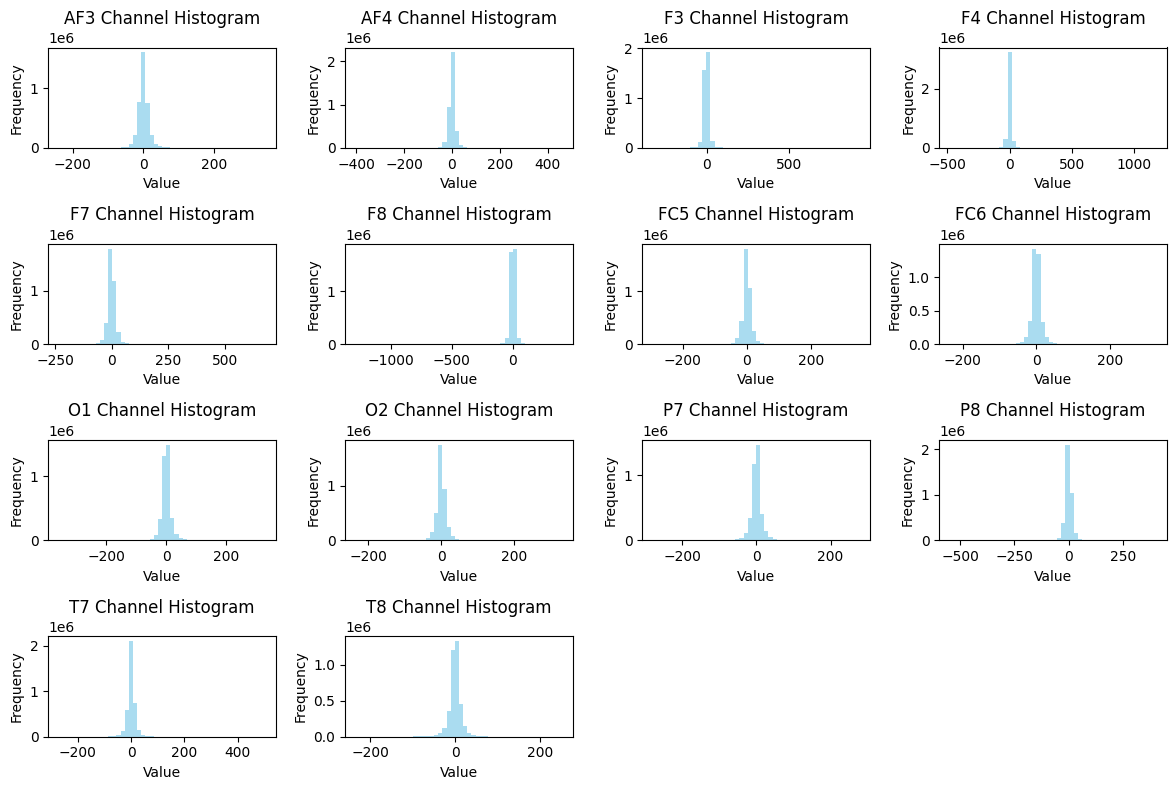

In [14]:
channel_names = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
# 3. Visualization
plt.figure(figsize=(12, 8))
for i in range(all_eeg_channels_array.shape[2]):
    plt.subplot(4, 4, i+1)
    plt.hist(all_eeg_channels_array[:,:,i].flatten(), bins=50, color='skyblue', alpha=0.7)
    plt.title(f"{channel_names[i]} Channel Histogram")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [15]:
'''
# 4. Visualization - Boxplot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
for i in range(all_eeg_channels_array.shape[2]):
    plt.subplot(4, 4, i+1)
    sns.boxplot(data=all_eeg_channels_array[:, :, i], color='skyblue')
    plt.title(f"{channel_names[i]} Channel Boxplot")
    plt.xlabel("EEG Channels")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()
'''

'\n# 4. Visualization - Boxplot\nplt.figure(figsize=(12, 8))\nsns.set(style="whitegrid")\nfor i in range(all_eeg_channels_array.shape[2]):\n    plt.subplot(4, 4, i+1)\n    sns.boxplot(data=all_eeg_channels_array[:, :, i], color=\'skyblue\')\n    plt.title(f"{channel_names[i]} Channel Boxplot")\n    plt.xlabel("EEG Channels")\n    plt.ylabel("Value")\nplt.tight_layout()\nplt.show()\n'

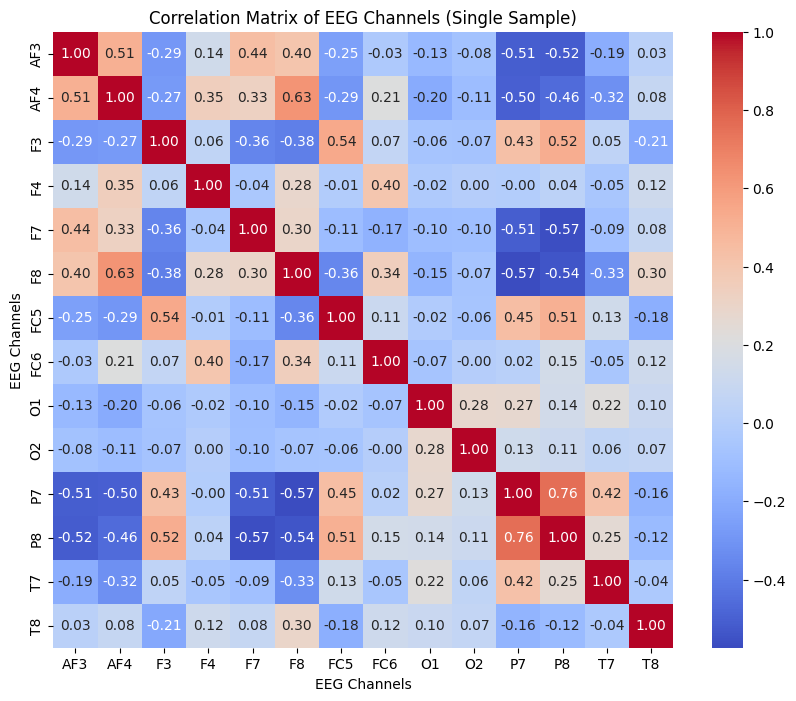

In [16]:
# Reduce the sample size for correlation analysis
sample_size = 1  # Sample size is now 1
sample_data = all_eeg_channels_array[0]  # Take the first sample

# Calculate correlation matrix for the sample data
corr_matrix = np.corrcoef(sample_data.T)

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f",
            xticklabels=['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8'],
            yticklabels=['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8'])
plt.title("Correlation Matrix of EEG Channels (Single Sample)")
plt.xlabel("EEG Channels")
plt.ylabel("EEG Channels")
plt.show()


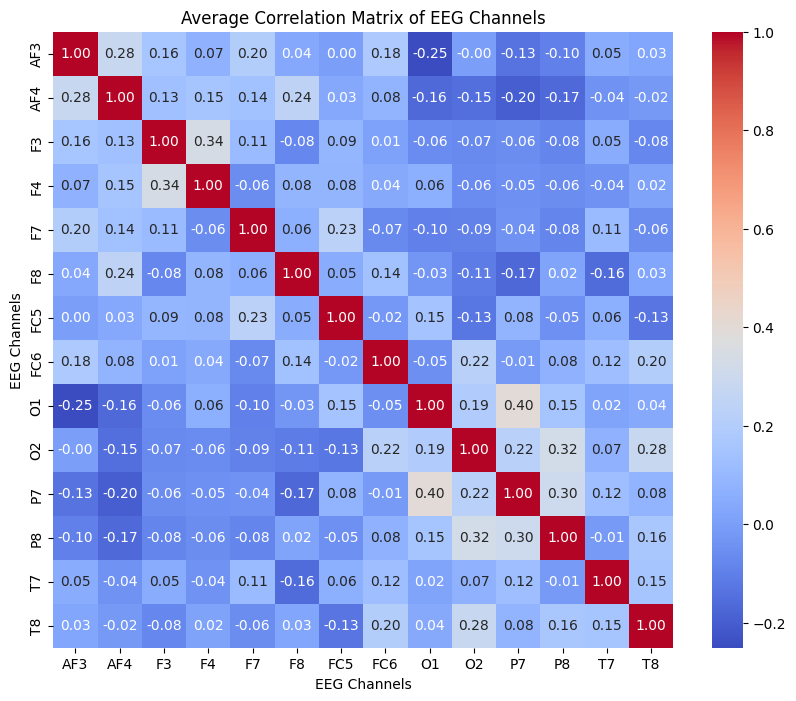

In [17]:
# Calculate correlation matrices for all samples
cor_matrices = np.array([np.corrcoef(sample.T) for sample in all_eeg_channels_array])

# Stack correlation matrices along a new dimension
stacked_cor_matrices = np.stack(cor_matrices, axis=2)

# Take the mean along the new dimension to get the average correlation matrix
average_cor_matrix = np.mean(stacked_cor_matrices, axis=2)

# Plot the average correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(average_cor_matrix, cmap='coolwarm', annot=True, fmt=".2f",
            xticklabels=['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8'],
            yticklabels=['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8'])
plt.title("Average Correlation Matrix of EEG Channels")
plt.xlabel("EEG Channels")
plt.ylabel("EEG Channels")
plt.show()


ValueError: The 'color' keyword argument must have one color per dataset, but 2 datasets and 1 colors were provided

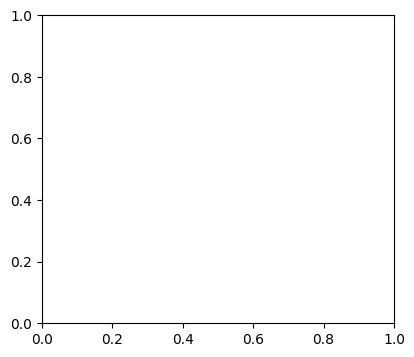

In [19]:
# 5. Label Analysis
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(all_labels_array[:,0], bins=20, color='skyblue', alpha=0.7)
plt.title("Valence Histogram")
plt.xlabel("Valence")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(all_labels_array[:,1], bins=20, color='salmon', alpha=0.7)
plt.title("Arousal Histogram")
plt.xlabel("Arousal")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [ ]:

# 6. Label Correlation
#label_corr = np.corrcoef(all_labels_array[:,0], all_labels_array[:,1])
#print("Correlation between Valence and Arousal Labels:", label_corr)
import seaborn as sns

# Calculate the correlation matrix
label_corr_matrix = np.corrcoef(all_labels_array[:,0], all_labels_array[:,1])

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(label_corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation between Valence and Arousal Labels")
plt.xlabel("Valence")
plt.ylabel("Arousal")
plt.show()


In [ ]:
# 3. Visualization: Data Distribution
plt.figure(figsize=(12, 8))
for i in range(all_eeg_channels_array.shape[2]):
    plt.subplot(4, 4, i+1)
    plt.hist(all_eeg_channels_array[:, :, i].flatten(), bins=50, color='skyblue', alpha=0.7)
    plt.title(f"{channel_names[i]} Channel Distribution")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [ ]:
# # Plot violin plot
# plt.figure(figsize=(12, 8))
# sns.violinplot(data=all_eeg_channels_array.reshape(-1, all_eeg_channels_array.shape[-1]),
#                palette='muted', inner='point')
# plt.title('Distribution of EEG Data Across Channels')
# plt.xlabel('Channels')
# plt.ylabel('EEG Data')
# plt.xticks(ticks=np.arange(all_eeg_channels_array.shape[-1]), labels=channel_names)
# plt.show()

In [4]:
import os

# Directory containing the CSV files
directory = '/kaggle/input/eeg-dataset-for-emotion-recognition/Data/'

# Initialize lists to store reshaped EEG channels and labels
all_reshaped_channels = []
all_labels = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        print(file_path)

        # Read the CSV file
        data = pd.read_csv(file_path)

        # Select the EEG channels columns and the first 38250 samples
        eeg_channels = data[['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']][:38250]

        # Define the number of segments
        num_segments = 6

        # Calculate the segment size
        segment_size = eeg_channels.shape[0] // num_segments

        # Define the number of subsegments
        num_subsegments = 5

        # Calculate the subsegment size
        subsegment_size = segment_size // num_subsegments

        # Reshape the EEG channels data into segments and subsegments
        reshaped_channels = eeg_channels.values.reshape(1, num_segments, eeg_channels.shape[1], num_subsegments, subsegment_size)

        # Select the first 6 rows for labels
        labels = data[['valence', 'arousal']][:6].values.reshape(1, 6, -1)

        # Append the reshaped EEG channels and labels to the lists
        all_reshaped_channels.append(reshaped_channels)
        all_labels.append(labels)

# Convert lists to arrays
all_reshaped_channels_array = np.concatenate(all_reshaped_channels, axis=0)
all_labels_array = np.concatenate(all_labels, axis=0)

# Print the shapes of the arrays
print("All Reshaped EEG Channels Array Shape:", all_reshaped_channels_array.shape)
print("All Labels Array Shape:", all_labels_array.shape)


/kaggle/input/eeg-dataset-for-emotion-recognition/Data/S25G1AllChannels.csv
/kaggle/input/eeg-dataset-for-emotion-recognition/Data/S10G2AllChannels.csv
/kaggle/input/eeg-dataset-for-emotion-recognition/Data/S07G4AllChannels.csv
/kaggle/input/eeg-dataset-for-emotion-recognition/Data/S02G2AllChannels.csv
/kaggle/input/eeg-dataset-for-emotion-recognition/Data/S05G1AllChannels.csv
/kaggle/input/eeg-dataset-for-emotion-recognition/Data/S15G4AllChannels.csv
/kaggle/input/eeg-dataset-for-emotion-recognition/Data/S22G4AllChannels.csv
/kaggle/input/eeg-dataset-for-emotion-recognition/Data/S21G1AllChannels.csv
/kaggle/input/eeg-dataset-for-emotion-recognition/Data/S15G3AllChannels.csv
/kaggle/input/eeg-dataset-for-emotion-recognition/Data/S23G4AllChannels.csv
/kaggle/input/eeg-dataset-for-emotion-recognition/Data/S04G1AllChannels.csv
/kaggle/input/eeg-dataset-for-emotion-recognition/Data/S01G1AllChannels.csv
/kaggle/input/eeg-dataset-for-emotion-recognition/Data/S16G4AllChannels.csv
/kaggle/inpu

In [5]:
#3d
# Reshape the EEG channels array
reshaped_channels_array = all_reshaped_channels_array.reshape(-1, all_reshaped_channels_array.shape[2],
                                                            all_reshaped_channels_array.shape[3],
                                                            all_reshaped_channels_array.shape[4])

# Reshape the labels array
reshaped_labels_array = all_labels_array.reshape(-1, all_labels_array.shape[2])

# Print the shapes of the reshaped arrays
print("Reshaped EEG Channels Array Shape:", reshaped_channels_array.shape)
print("Reshaped Labels Array Shape:", reshaped_labels_array.shape)


Reshaped EEG Channels Array Shape: (600, 14, 5, 1275)
Reshaped Labels Array Shape: (600, 2)


In [6]:
#3d
def map_labels(valence, arousal):
    if valence <= 2.5 and arousal <= 2.5:
        return 0  # neg valence, low arousal
    elif valence <= 2.5 and arousal > 2.5:
        return 1  # neg valence, high arousal
    elif valence > 2.5 and arousal <= 2.5:
        return 2  # pos valence, low arousal
    else:
        return 3  # pos valence, high arousal

# Example usage:
reshaped_labels_mapped = np.array([map_labels(valence, arousal) for valence, arousal in reshaped_labels_array])
reshaped_labels_mapped

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

# Preprocessing

**Filtering**

In [40]:
all_eeg_channels_array.shape[2]

14

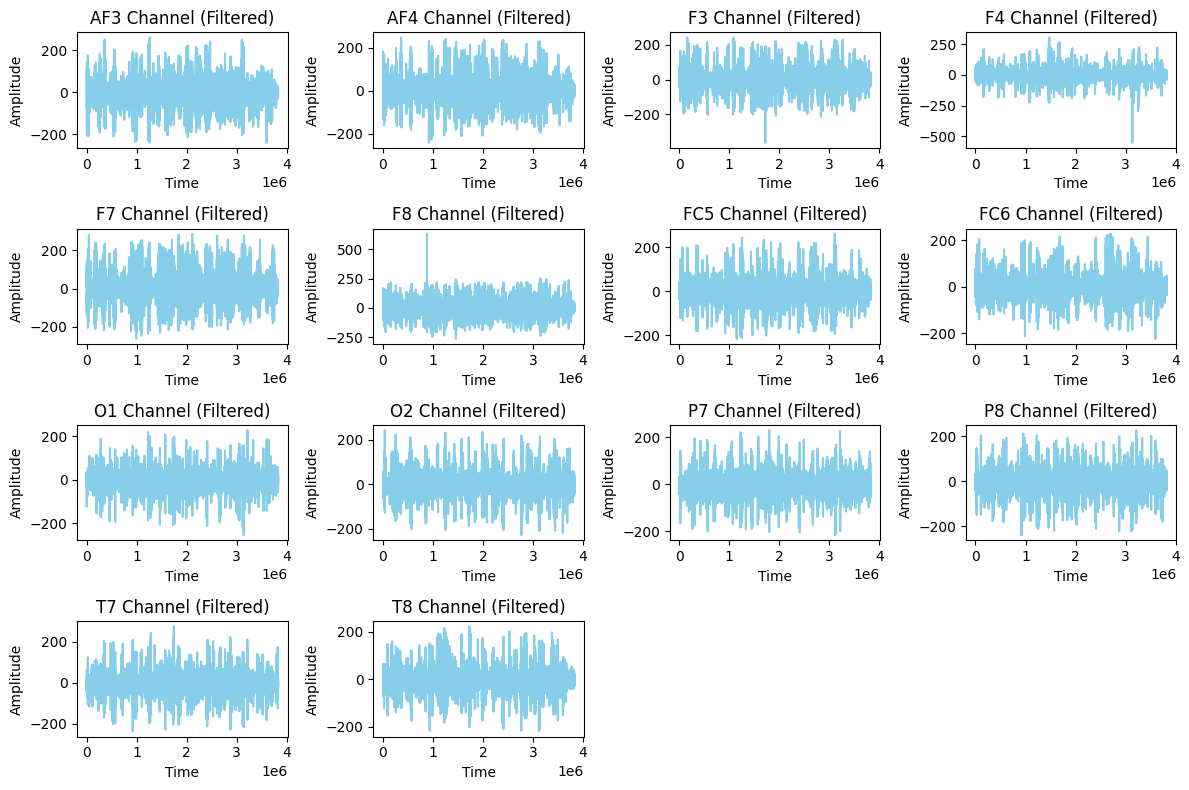

In [41]:
from scipy.signal import butter, filtfilt
channel_names = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']

# Define filter parameters
lowcut = 0.5  # Lower cutoff frequency in Hz
highcut = 45  # Upper cutoff frequency in Hz
fs = 128      # Sampling frequency in Hz
order = 4     # Filter order

# Function to create Butterworth bandpass filter coefficients
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply the Butterworth bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Apply the filter to each EEG channel
filtered_data = np.zeros_like(all_eeg_channels_array)
for i in range(all_eeg_channels_array.shape[2]):
    filtered_data[:,:,i] = butter_bandpass_filter(all_eeg_channels_array[:,:,i], lowcut, highcut, fs, order)

# Visualize the filtered data
plt.figure(figsize=(12, 8))
for i in range(filtered_data.shape[2]):
    plt.subplot(4, 4, i+1)
    plt.plot(filtered_data[:,:,i].flatten(), color='skyblue')
    plt.title(f"{channel_names[i]} Channel (Filtered)")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


# 3d Filter

(100, 38250, 14)

<ipython-input-8-1a59adc7ef77>:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


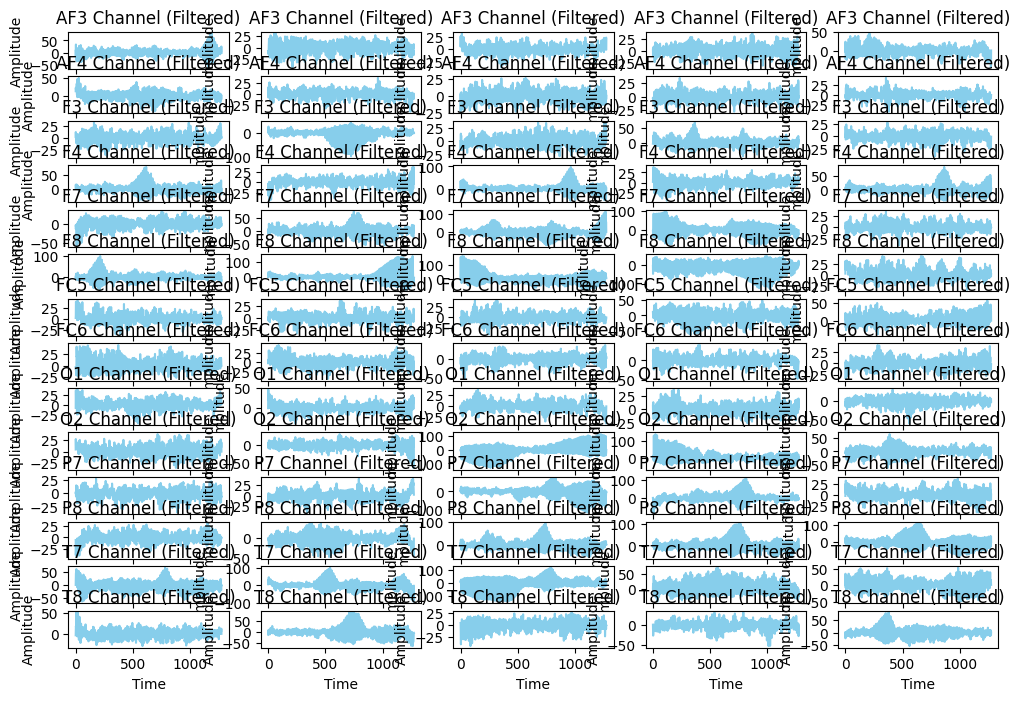

In [8]:
from scipy.signal import butter, filtfilt
channel_names = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']

# Define filter parameters
lowcut = 0.5  # Lower cutoff frequency in Hz
highcut = 45  # Upper cutoff frequency in Hz
fs = 128      # Sampling frequency in Hz
order = 4     # Filter order

# Function to create Butterworth bandpass filter coefficients
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply the Butterworth bandpass filter to a 3D array
def butter_bandpass_filter_3d(data, lowcut, highcut, fs, order=4):
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            b, a = butter_bandpass(lowcut, highcut, fs, order=order)
            filtered_data[i, j, :, :] = filtfilt(b, a, data[i, j, :, :])
    return filtered_data

# Apply the filter to the EEG channels data
filtered_data = butter_bandpass_filter_3d(reshaped_channels_array, lowcut, highcut, fs, order)

# Visualize the filtered data for each channel
plt.figure(figsize=(12, 8))
for i in range(filtered_data.shape[1]):
    for j in range(filtered_data.shape[2]):
        plt.subplot(14, 5, i*5 + j + 1)
        plt.plot(filtered_data[0, i, j, :].flatten(), color='skyblue')
        plt.title(f"{channel_names[i]} Channel (Filtered)")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()



In [43]:
#no need after 3d reading
filtered_data_reshaped = filtered_data.transpose(0, 2, 1)
print("Reshaped Filtered Data Shape:", filtered_data_reshaped.shape)

filtered_data.shape

Reshaped Filtered Data Shape: (100, 14, 38250)


(100, 38250, 14)

In [44]:
#no need after 3d reading
import numpy as np

# Assuming filtered_data is your original data with shape (100, 14, 38252)
reshaped_filtered_data = filtered_data.reshape(100, 14, 6, 6375)
reshaped_filtered_data = reshaped_filtered_data.transpose(0, 2, 1, 3)
# Check the shape of the reshaped data
print("Reshaped Filtered Data Shape:", reshaped_filtered_data.shape)



Reshaped Filtered Data Shape: (100, 6, 14, 6375)


# Feature Extraction

In [ ]:
'''import numpy as np
from scipy.stats import entropy

# Define the number of segments
num_segments = 6

# Define a function to compute differential entropy for a given EEG channel
def compute_differential_entropy(channel_data):
    # Estimate probability density function using histogram-based method
    hist, bin_edges = np.histogram(channel_data, bins='auto', density=True)

    # Compute entropy
    entropy_value = entropy(hist, base=2)  # Use base 2 for entropy calculation

    return entropy_value

# Compute differential entropy for each segment in the dataset
num_samples = filtered_data.shape[0]
num_channels = filtered_data.shape[2]
segment_size = filtered_data.shape[1] // num_segments

differential_entropy_features = []

for sample_idx in range(num_samples):
    sample_segment_entropy = []

    for segment_idx in range(num_segments):
        segment_entropy = []

        # Calculate start and end indices for the segment
        start_idx = segment_idx * segment_size
        end_idx = start_idx + segment_size

        for i in range(num_channels):
            channel_data = filtered_data[sample_idx, start_idx:end_idx, i]
            channel_segment_entropy = []
            for point_idx in range(len(channel_data)):
                point_data = channel_data[point_idx]
                entropy_value = compute_differential_entropy(point_data)
                channel_segment_entropy.append(entropy_value)

            segment_entropy.append(channel_segment_entropy)

        sample_segment_entropy.append(segment_entropy)

    differential_entropy_features.append(sample_segment_entropy)

# Convert the list to a numpy array
differential_entropy_features = np.array(differential_entropy_features)

# Print the shapes of the features and labels
print("Differential Entropy Features Shape:", differential_entropy_features.shape)
print("Labels Shape:", all_labels_array.shape)
'''


In [26]:
import numpy as np
from scipy.stats import entropy

# Assuming you have filtered EEG data stored in filtered_data variable
# Assuming labels are stored in all_labels_array variable

# Define a function to compute differential entropy for a given EEG channel
def compute_differential_entropy(channel_data):
    # Estimate probability density function using histogram-based method
    hist, bin_edges = np.histogram(channel_data, bins='auto', density=True)

    # Compute entropy
    entropy_value = entropy(hist, base=2)  # Use base 2 for entropy calculation

    return entropy_value

# Compute differential entropy for each sample in the dataset
num_samples = filtered_data.shape[0]
num_channels = filtered_data.shape[2]
differential_entropy_features = []
for sample_idx in range(num_samples):
    sample_entropy = []
    for i in range(num_channels):
        channel_data = filtered_data[sample_idx, :, i]
        entropy_value = compute_differential_entropy(channel_data)
        sample_entropy.append(entropy_value)
    differential_entropy_features.append(sample_entropy)

# Convert the list to a numpy array
differential_entropy_features = np.array(differential_entropy_features)

# Print the shapes of the features and labels
print("Differential Entropy Features Shape:", differential_entropy_features.shape)
print("Labels Shape:", all_labels_array.shape)


Differential Entropy Features Shape: (600, 5)
Labels Shape: (100, 6, 2)


In [9]:
import numpy as np
from scipy.stats import entropy

# Reshape the reshaped_channels_array to (600, 14, 5, 1275)
reshaped_channels_array = reshaped_channels_array.reshape(600, 14, 5, 1275)

# Function to compute differential entropy for a given EEG segment
def compute_differential_entropy(segment):
    # Estimate probability density function using histogram-based method
    hist, bin_edges = np.histogram(segment, bins='auto', density=True)
    # Compute entropy
    entropy_values = entropy(hist, base=2)  # Use base 2 for entropy calculation
    return entropy_values

# Compute differential entropy for each segment
differential_entropy_features = np.zeros((600, 14, 5, 1275))
for i in range(600):
    for j in range(14):
        for k in range(5):
            segment = reshaped_channels_array[i, j, k, :]
            differential_entropy_features[i, j, :, k] = compute_differential_entropy(segment)

# Swap the last two dimensions
differential_entropy_features = np.swapaxes(differential_entropy_features, -1, -2)

# Check the shape of the computed features
print("Differential Entropy Features Shape:", differential_entropy_features.shape)


Differential Entropy Features Shape: (600, 14, 1275, 5)


In [10]:
data = differential_entropy_features
labels_edited = reshaped_labels_mapped
data.shape

(600, 14, 1275, 5)

In [11]:
from sklearn.utils import shuffle
#(675, 62, 265, 5)(675,)
#(600, 14, 5, 1275) (600,)
differential_entropy_features, reshaped_labels_mapped = shuffle(differential_entropy_features, reshaped_labels_mapped)

# Traing

In [12]:
!pip install keras-tuner
!pip install mat73
!pip install -U tensorflow-addons

#from google.colab import drive
#drive.mount('/content/drive')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
import mat73
from keras.callbacks import ReduceLROnPlateau
import sklearn.metrics
from sklearn.utils import shuffle
from tensorflow.keras import layers
#import tensorflow_addons as tfa
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Conv3D, MaxPooling3D, BatchNormalization
import matplotlib.pyplot as plt
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 34.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [13]:
import tensorflow.keras as keras
#import tensorflow_addons as tfa

In [ ]:
#**OLD trainging **

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming you have the following shapes for features and labels
# differential_entropy_features.shape: (100, 14)
# all_labels_array.shape: (100, 2)

# Selecting only arousal labels
arousal_labels = all_labels_array[:, 1]  # Assuming arousal is the second column

# Reshaping features to add channel dimension (required for CNN)
differential_entropy_features = differential_entropy_features.reshape(-1, 14, 1)

# Splitting data into training and validation sets
train_ratio = 0.8
train_size = int(train_ratio * len(differential_entropy_features))

train_features = differential_entropy_features[:train_size]
train_labels = arousal_labels[:train_size]
val_features = differential_entropy_features[train_size:]
val_labels = arousal_labels[train_size:]

# Define the CNN model
model = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(14, 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer with 1 neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


In [32]:
# Train the model
history = model.fit(train_features, train_labels, epochs=10, batch_size=16, validation_data=(val_features, val_labels))

# Evaluate the model on the validation set
val_loss, val_mae = model.evaluate(val_features, val_labels)

print("Validation Loss:", val_loss)
print("Validation MAE:", val_mae)


NameError: name 'model' is not defined

**Colab traing**

In [14]:
cumul = []
for i in range(4): cumul.append([])

In [15]:
max_val = np.max(data)
min_val = np.min(data)

# Normalizing data
data = data / max_val
data = (data - np.mean(data)) / np.std(data)

# Cropping end time segments
data = data[:, :, 0:1250, :]

# Splitting Dataset into train, validation, test
train_labels = labels_edited[0:520]
test_labels = labels_edited[520:560]
final_labels = labels_edited[560:600]

train_data = data[0:520]
test_data = data[520:560]
final_test = data[560:600]

cf_labels = np.where(final_labels == -1, 3, final_labels)  # Label in the form for confusion matrix
un, co = np.unique(cf_labels, return_counts=True)
print(f'Unique: {un}, Counts: {co}')

train_labels_reshaped = train_labels.reshape(-1, 1)  # Formatting for input to the CNN model
test_labels_reshaped = test_labels.reshape(-1, 1)
final_labels_reshaped = final_labels.reshape(-1, 1)

train_labels_reshaped = to_categorical(train_labels_reshaped, 4)  # One Hot Encoding
test_labels_reshaped = to_categorical(test_labels_reshaped, 4)
final_labels_reshaped = to_categorical(final_labels_reshaped, 4)

rnn_train = train_data.reshape(520, 14, -1)  # Formatting for RNN input
rnn_test = test_data.reshape(40, 14, -1)
rnn_train = np.transpose(rnn_train, (0, 2, 1))
rnn_test = np.transpose(rnn_test, (0, 2, 1))

print(train_data.shape, rnn_train.shape)


Unique: [0 1 2], Counts: [12  4 24]
(520, 14, 1250, 5) (520, 6250, 14)


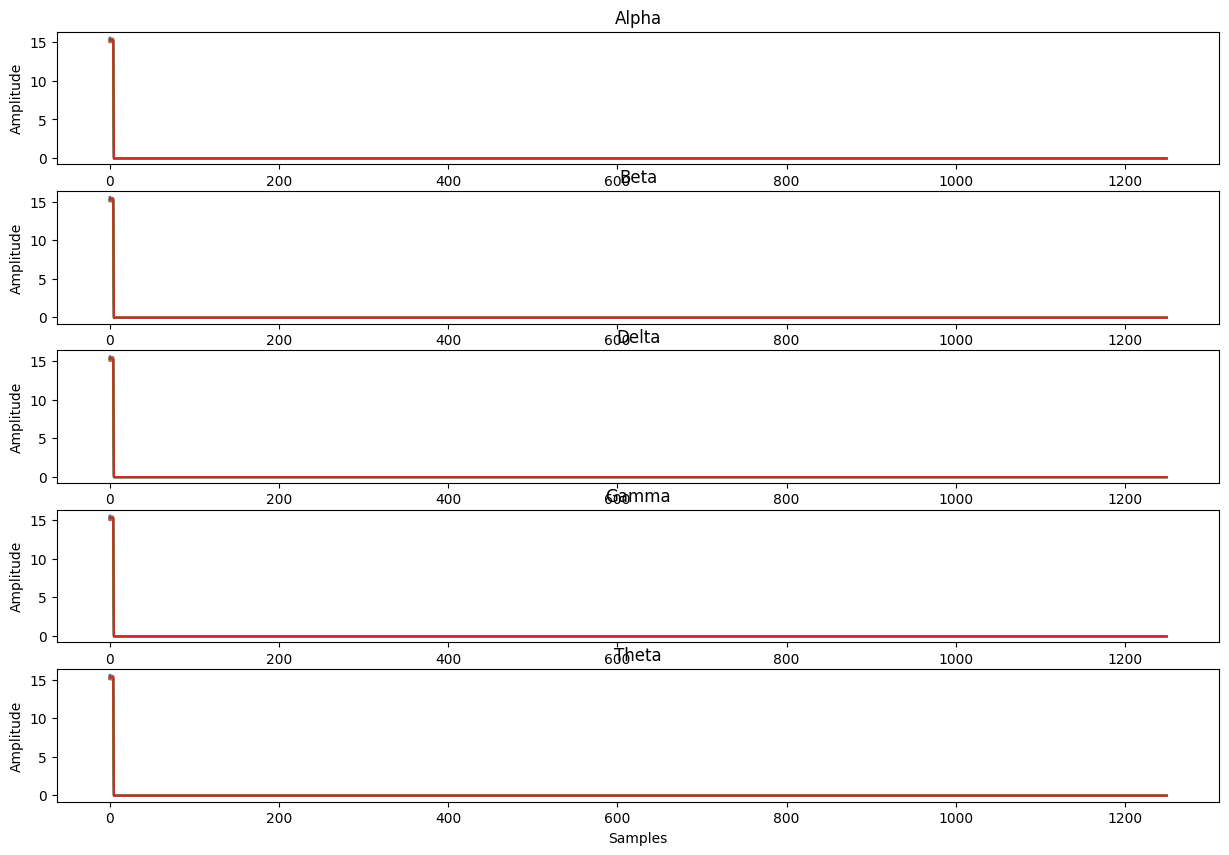

In [16]:
fig, a = plt.subplots(5, 1, squeeze= False, figsize= (15, 10))
titles = ['Alpha', 'Beta', 'Delta', 'Gamma', 'Theta']
for cnt in range(5):
  for i in range(len(test_data[5])):
    a[cnt][0].plot(range(len(test_data[5][i,:,cnt])), test_data[5][i,:,cnt])
  a[cnt][0].set_title(titles[cnt])
  a[cnt][0].set_xlabel('Samples')
  a[cnt][0].set_ylabel('Amplitude')

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential([
    Conv2D(filters=64, kernel_size=5, input_shape=(14, 1250, 5), padding='same'),
    Conv2D(filters=64, kernel_size=3, padding='same'),
    Conv2D(filters=64, kernel_size=3, padding='same'),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),  # Adjusted max-pooling layer
    Dropout(rate=0.3),
    Conv2D(filters=128, kernel_size=3, padding='same'),
    Conv2D(filters=128, kernel_size=3, padding='same'),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),  # Adjusted max-pooling layer
    Dropout(rate=0.2),
    Conv2D(filters=256, kernel_size=3, padding='same'),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),  # Adjusted max-pooling layer
    Dropout(rate=0.25),
    Conv2D(filters=512, kernel_size=3, padding='same'),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),  # Adjusted max-pooling layer
    Dropout(rate=0.3),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.4),
    Dense(256, activation='relu'),
    Dropout(rate=0.2),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=9e-5),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 1250, 64)        │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 1250, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 1250, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 7, 625, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 625, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 625, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 625, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 313, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 313, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 313, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 157, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 157, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 2, 157, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 79, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 79, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 40448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      20,709,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 22,636,612 (86.35 MB)

 Trainable params: 22,636,612 (86.35 MB)

 Non-trainable params: 0 (0.00 B)

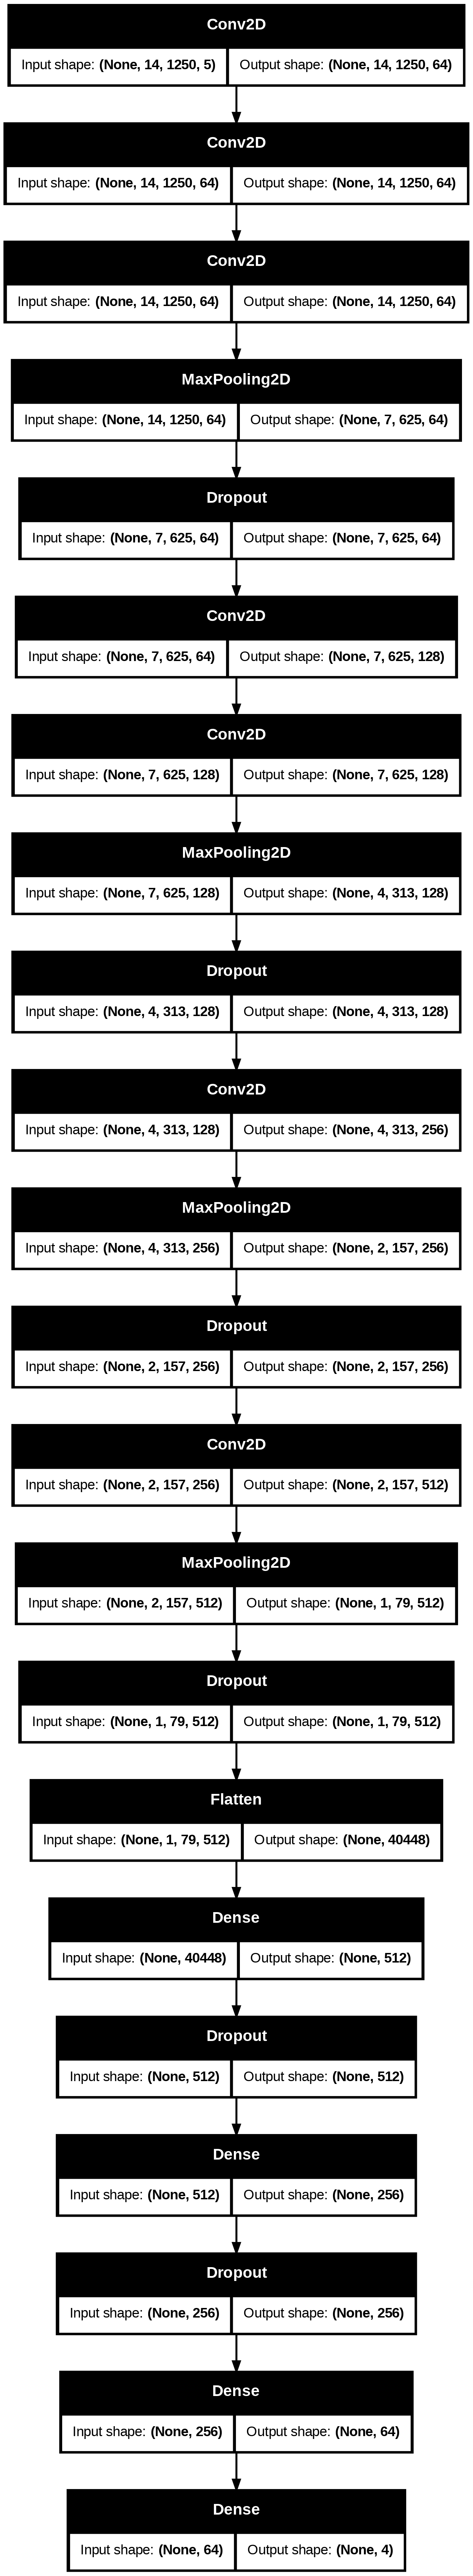

In [18]:
dot_img_file = 'model CNN .png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [19]:
#Training our CNN model using a learning rate annealer (Reduces LR on Plateaus)
reduce_lr_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7) #patience = 5 and factor = 0.9

history = model.fit(
  train_data,
  train_labels_reshaped,
  batch_size = 128,
  epochs=100,
  validation_data=(test_data, test_labels_reshaped),
  callbacks = [reduce_lr_cnn]
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step - accuracy: 0.3209 - loss: 1.3756 - root_mean_squared_error: 0.4311 - val_accuracy: 0.5000 - val_loss: 1.2754 - val_root_mean_squared_error: 0.4163 - learning_rate: 9.0000e-05
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.3880 - loss: 1.3493 - root_mean_squared_error: 0.4269 - val_accuracy: 0.5000 - val_loss: 1.2925 - val_root_mean_squared_error: 0.4188 - learning_rate: 9.0000e-05
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - accuracy: 0.4116 - loss: 1.3283 - root_mean_squared_error: 0.4240 - val_accuracy: 0.5000 - val_loss: 1.2800 - val_root_mean_squared_error: 0.4161 - learning_rate: 9.0000e-05
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - accuracy: 0.3943 - loss: 1.3442 - root_mean_squared_error: 0.4251 - val_accuracy: 0.5000 - val_loss: 1.2974 - val_root_mean_squared_error: 0.4197 - learning_rate: 9.0000e-05
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 0.3922 - loss: 1.3365 - root_me